# Gaussian generative models for handwritten digit classification

Recall that the 1-NN classifier yielded a 3.09% test error rate on the MNIST data set of handwritten digits. We will now see that a Gaussian generative model does almost as well, while being significantly faster and more compact.

## 1. Set up notebook and load in data

As usual, we start by importing the required packages and data. For this notebook we will be using the *entire* `MNIST` dataset. The code below defines some helper functions that will load `MNIST` onto your computer.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt 
import gzip, os, sys
import numpy as np
from scipy.stats import multivariate_normal

if sys.version_info[0] == 2:
    from urllib import urlretrieve
else:
    from urllib.request import urlretrieve

In [2]:
# Function that downloads a specified MNIST data file from Yann Le Cun's website
def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
    print("Downloading %s" % filename)
    urlretrieve(source + filename, filename)

# Invokes download() if necessary, then reads in images
def load_mnist_images(filename):
    if not os.path.exists(filename):
        download(filename)
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1,784)
    return data

def load_mnist_labels(filename):
    if not os.path.exists(filename):
        download(filename)
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
    return data

Now load in the training set and test set

In [3]:
## Load the training set
train_data = load_mnist_images('train-images-idx3-ubyte.gz')
train_labels = load_mnist_labels('train-labels-idx1-ubyte.gz')

## Load the testing set
test_data = load_mnist_images('t10k-images-idx3-ubyte.gz')
test_labels = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

The function **displaychar** shows a single MNIST digit. To do this, it first has to reshape the 784-dimensional vector into a 28x28 image.

In [4]:
def displaychar(image):
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.axis('off')
    plt.show()

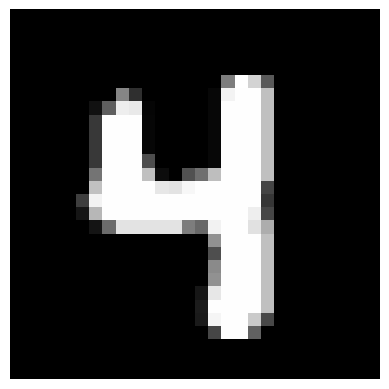

In [5]:
displaychar(train_data[58])

The training set consists of 60,000 images. Thus `train_data` should be a 60000x784 array while `train_labels` should be 60000x1. Let's check.

In [6]:
train_data.shape, train_labels.shape

((60000, 784), (60000,))

## 2. Fit a Gaussian generative model to the training data

**<font color="magenta">For you to do:</font>** Define a function, **fit_generative_model**, that takes as input a training set (data `x` and labels `y`) and fits a Gaussian generative model to it. It should return the parameters of this generative model; for each label `j = 0,1,...,9`, we have:
* `pi[j]`: the frequency of that label
* `mu[j]`: the 784-dimensional mean vector
* `sigma[j]`: the 784x784 covariance matrix

This means that `pi` is 10x1, `mu` is 10x784, and `sigma` is 10x784x784.

We have already seen how to fit a Gaussian generative model in the Winery example, but now there is an added ingredient. <font color="magenta">The empirical covariances are very likely to be singular (or close to singular), which means that we won't be able to do calculations with them</font>. Thus it is important to **regularize** these matrices. The standard way of doing this is to add `cI` to them, where `c` is some constant and `I` is the 784-dimensional identity matrix. (To put it another way, we compute the empirical covariances and then increase their diagonal entries by some constant `c`.)

This modification is guaranteed to yield covariance matrices that are non-singular, for any `c > 0`, no matter how small. But this doesn't mean that we should make `c` as small as possible. Indeed, `c` is now a parameter, and by setting it appropriately, we can improve the performance of the model. We will study **regularization** in greater detail over the coming weeks.

Your routine needs to choose a good setting of `c`. Crucially, this needs to be done using the training set alone. So you might try setting aside part of the training set as a validation set, or using some kind of cross-validation.

In [9]:
v = np.nonzero(train_labels == 1)[0]
train_data[v].shape, v.shape
ar = np.zeros((10, 784))
ar[0,:] = np.mean(train_data[v], axis=0)
np.cov(train_data[v].T).shape

(784, 784)

In [17]:
def fit_generative_model(x, y, c):
  k = 10  # labels 0,1,...,k-1
  d = (x.shape)[1]  # number of features
  mu = np.zeros((k,d))
  sigma = np.zeros((k,d,d))
  pi = np.zeros(k)
  ###
  ### Your code goes here
  ###
  for num in range(k):
    idxs = np.nonzero(train_labels == num)[0]
    vals = x[idxs]
    mu[num,:] = np.mean(vals, axis=0)
    sigma[num,:,:] = np.cov(vals.T) + c * np.eye(784)
    pi[num] = len(idxs) / len(x)
    
  # Halt and return parameters
  return mu, sigma, pi

Okay, let's try out your function. In particular, we will use **displaychar** to visualize the means of the Gaussians for the first three digits. You can try the other digits on your own.

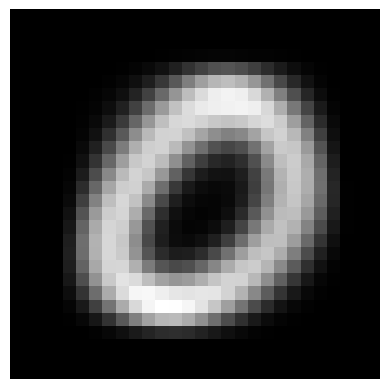

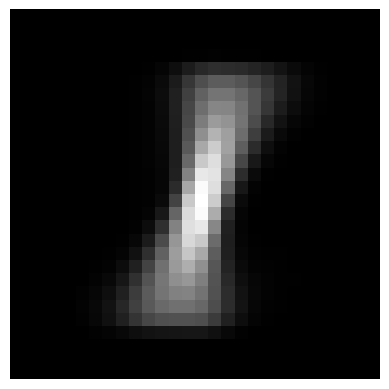

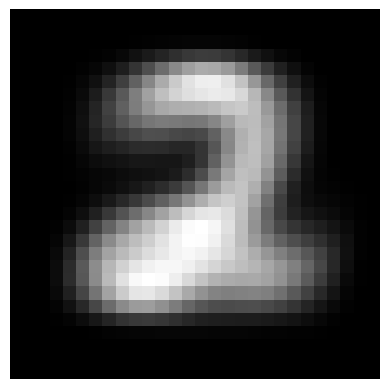

In [18]:
c = 0.1
mu, sigma, pi = fit_generative_model(train_data, train_labels, c = 0.1)
displaychar(mu[0])
displaychar(mu[1])
displaychar(mu[2])

## 3. Make predictions on test data

Now let's see how many errors your model makes on the test set.

In [23]:
# Compute log Pr(label|image) for each [test image,label] pair.
cs = [2**i for i in range(5, 18)]
k = 10
for c in cs:
  mu, sigma, pi = fit_generative_model(train_data, train_labels, c = c)
  score = np.zeros((len(test_labels),k))
  for label in range(0,k):
      rv = multivariate_normal(mean=mu[label], cov=sigma[label])
      for i in range(0,len(test_labels)):
        score[i,label] = np.log(pi[label]) + rv.logpdf(test_data[i,:])
  predictions = np.argmax(score, axis=1)
  # Finally, tally up score
  errors = np.sum(predictions != test_labels)
  print(f"c={c}, Err:{str(errors)}/10000, {errors/10000}")
  # print("Your model makes " + str(errors) + " errors out of 10000")

c=32, Err:1018/10000, 0.1018
c=64, Err:894/10000, 0.0894
c=128, Err:766/10000, 0.0766
c=256, Err:648/10000, 0.0648
c=512, Err:559/10000, 0.0559
c=1024, Err:486/10000, 0.0486
c=2048, Err:435/10000, 0.0435
c=4096, Err:431/10000, 0.0431
c=8192, Err:492/10000, 0.0492
c=16384, Err:598/10000, 0.0598
c=32768, Err:801/10000, 0.0801
c=65536, Err:1155/10000, 0.1155
c=131072, Err:1634/10000, 0.1634


In [25]:
# Compute log Pr(label|image) for each [test image,label] pair.
cs = np.linspace(1024, 8192, 20).astype(np.int32)
k = 10
for c in cs:
  mu, sigma, pi = fit_generative_model(train_data, train_labels, c = c)
  score = np.zeros((len(test_labels),k))
  for label in range(0,k):
      rv = multivariate_normal(mean=mu[label], cov=sigma[label])
      for i in range(0,len(test_labels)):
        score[i,label] = np.log(pi[label]) + rv.logpdf(test_data[i,:])
  predictions = np.argmax(score, axis=1)
  # Finally, tally up score
  errors = np.sum(predictions != test_labels)
  print(f"c={c}, Err:{str(errors)}/10000, {errors/10000}")
  # print("Your model makes " + str(errors) + " errors out of 10000")

c=1024, Err:486/10000, 0.0486
c=1401, Err:456/10000, 0.0456
c=1778, Err:440/10000, 0.044
c=2155, Err:436/10000, 0.0436
c=2533, Err:434/10000, 0.0434
c=2910, Err:431/10000, 0.0431
c=3287, Err:437/10000, 0.0437
c=3664, Err:435/10000, 0.0435
c=4042, Err:431/10000, 0.0431
c=4419, Err:436/10000, 0.0436
c=4796, Err:438/10000, 0.0438
c=5173, Err:439/10000, 0.0439
c=5551, Err:438/10000, 0.0438
c=5928, Err:445/10000, 0.0445
c=6305, Err:455/10000, 0.0455
c=6682, Err:463/10000, 0.0463
c=7060, Err:474/10000, 0.0474
c=7437, Err:475/10000, 0.0475
c=7814, Err:481/10000, 0.0481
c=8192, Err:492/10000, 0.0492


Best Results:

c=4096 = 431/10000, 0.0431

## 4. Quick exercises

*You will need to answer variants of these questions as part of this week's assignment*.

<font color="magenta">Exercise 1:</font> What happens if you do not regularize the covariance matrices?

Answer: An error is thrown saying that the covariance matrix is not positive semidefinite

In [26]:
mu, sigma, pi = fit_generative_model(train_data, train_labels, c = 0)
score = np.zeros((len(test_labels),k))
for label in range(0,k):
    rv = multivariate_normal(mean=mu[label], cov=sigma[label])
    for i in range(0,len(test_labels)):
      score[i,label] = np.log(pi[label]) + rv.logpdf(test_data[i,:])
predictions = np.argmax(score, axis=1)
# Finally, tally up score
errors = np.sum(predictions != test_labels)
print(f"c={c}, Err:{str(errors)}/10000, {errors/10000}")

LinAlgError: When `allow_singular is False`, the input matrix must be symmetric positive definite.

<font color="magenta">Exercise 2:</font> What happens if you set the value of `c` too high, for instance to one billion? Do you understand why this happens?

The error skyrockets to around 0.9. This means that the variances are all so insanely high and (relatively) equal that the classifier is just guessing at this point (10\% to be right, 1 - 0.1 = 0.9 Error)

In [28]:
c = 1E9
mu, sigma, pi = fit_generative_model(train_data, train_labels, c = 1E9)
score = np.zeros((len(test_labels),k))
for label in range(0,k):
    rv = multivariate_normal(mean=mu[label], cov=sigma[label])
    for i in range(0,len(test_labels)):
      score[i,label] = np.log(pi[label]) + rv.logpdf(test_data[i,:])
predictions = np.argmax(score, axis=1)
# Finally, tally up score
errors = np.sum(predictions != test_labels)
print(f"c={c}, Err:{str(errors)}/10000, {errors/10000}")

c=1000000000.0, Err:8865/10000, 0.8865


<font color="magenta">Exercise 3:</font> What value of c did you end up using? How many errors did your model make on the training set?

Best Results:

c=4096 = 431/10000, 0.0431

<font color="magenta">If you have the time</font>: We have talked about using the same regularization constant `c` for all ten classes. What about using a different value of `c` for each class? How would you go about choosing these? Can you get better performance in this way?

# Q15 part d

In [29]:
c=4096
mu, sigma, pi = fit_generative_model(train_data, train_labels, c = c)
score = np.zeros((len(test_labels),k))
for label in range(0,k):
    rv = multivariate_normal(mean=mu[label], cov=sigma[label])
    for i in range(0,len(test_labels)):
      score[i,label] = np.log(pi[label]) + rv.logpdf(test_data[i,:])
predictions = np.argmax(score, axis=1)

=== Test Sample 318, True label 2, Predicted Label 3
	[0], log(P(0|x)) =   -32.0909, P(0|x) = 0.000000
	[1], log(P(1|x)) =  -332.9169, P(1|x) = 0.000000
	[2], log(P(2|x)) =    -4.6146, P(2|x) = 0.009906
	[3], log(P(3|x)) =    -0.0100, P(3|x) = 0.990094
	[4], log(P(4|x)) =  -144.9549, P(4|x) = 0.000000
	[5], log(P(5|x)) =   -67.2531, P(5|x) = 0.000000
	[6], log(P(6|x)) =   -85.4842, P(6|x) = 0.000000
	[7], log(P(7|x)) =  -193.1079, P(7|x) = 0.000000
	[8], log(P(8|x)) =   -48.3429, P(8|x) = 0.000000
	[9], log(P(9|x)) =  -139.9801, P(9|x) = 0.000000


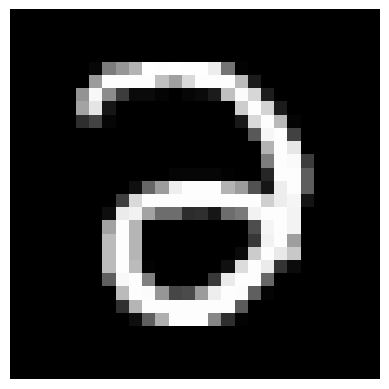

=== END Test Sample 318
=== Test Sample 4075, True label 8, Predicted Label 3
	[0], log(P(0|x)) =    -7.1375, P(0|x) = 0.000795
	[1], log(P(1|x)) =  -210.7206, P(1|x) = 0.000000
	[2], log(P(2|x)) =   -55.6330, P(2|x) = 0.000000
	[3], log(P(3|x)) =    -0.0015, P(3|x) = 0.998463
	[4], log(P(4|x)) =  -122.1122, P(4|x) = 0.000000
	[5], log(P(5|x)) =    -7.2054, P(5|x) = 0.000743
	[6], log(P(6|x)) =   -20.0997, P(6|x) = 0.000000
	[7], log(P(7|x)) =  -145.3032, P(7|x) = 0.000000
	[8], log(P(8|x)) =   -29.0186, P(8|x) = 0.000000
	[9], log(P(9|x)) =  -117.2421, P(9|x) = 0.000000


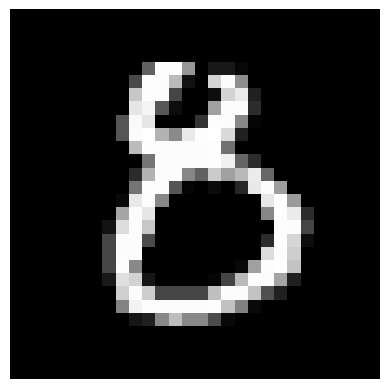

=== END Test Sample 4075
=== Test Sample 5634, True label 2, Predicted Label 3
	[0], log(P(0|x)) =   -21.6116, P(0|x) = 0.000000
	[1], log(P(1|x)) =  -159.0485, P(1|x) = 0.000000
	[2], log(P(2|x)) =    -5.5562, P(2|x) = 0.003863
	[3], log(P(3|x)) =    -0.0039, P(3|x) = 0.996137
	[4], log(P(4|x)) =  -106.6081, P(4|x) = 0.000000
	[5], log(P(5|x)) =   -36.3990, P(5|x) = 0.000000
	[6], log(P(6|x)) =   -57.3229, P(6|x) = 0.000000
	[7], log(P(7|x)) =  -164.6690, P(7|x) = 0.000000
	[8], log(P(8|x)) =   -22.7409, P(8|x) = 0.000000
	[9], log(P(9|x)) =   -98.3070, P(9|x) = 0.000000


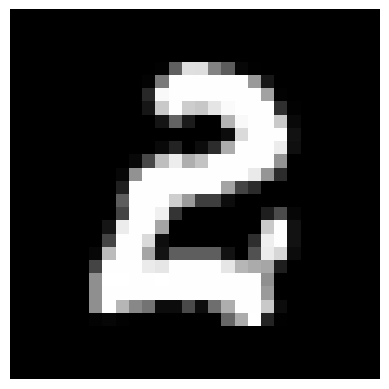

=== END Test Sample 5634
=== Test Sample 3448, True label 3, Predicted Label 0
	[0], log(P(0|x)) =    -0.0565, P(0|x) = 0.945054
	[1], log(P(1|x)) =   -98.0978, P(1|x) = 0.000000
	[2], log(P(2|x)) =   -14.1049, P(2|x) = 0.000001
	[3], log(P(3|x)) =    -2.9015, P(3|x) = 0.054941
	[4], log(P(4|x)) =   -77.1284, P(4|x) = 0.000000
	[5], log(P(5|x)) =   -23.9923, P(5|x) = 0.000000
	[6], log(P(6|x)) =   -12.5495, P(6|x) = 0.000004
	[7], log(P(7|x)) =  -101.9319, P(7|x) = 0.000000
	[8], log(P(8|x)) =   -54.2855, P(8|x) = 0.000000
	[9], log(P(9|x)) =   -84.3225, P(9|x) = 0.000000


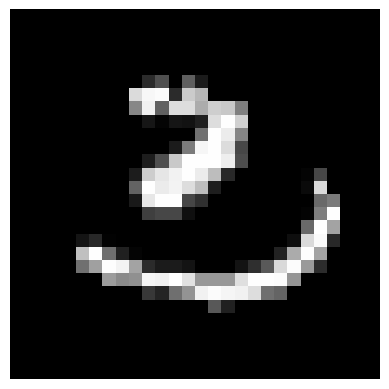

=== END Test Sample 3448
=== Test Sample 3751, True label 7, Predicted Label 1
	[0], log(P(0|x)) =   -59.4037, P(0|x) = 0.000000
	[1], log(P(1|x)) =    -0.0028, P(1|x) = 0.997248
	[2], log(P(2|x)) =   -16.9286, P(2|x) = 0.000000
	[3], log(P(3|x)) =   -34.4119, P(3|x) = 0.000000
	[4], log(P(4|x)) =    -7.1000, P(4|x) = 0.000825
	[5], log(P(5|x)) =   -34.1022, P(5|x) = 0.000000
	[6], log(P(6|x)) =   -32.8499, P(6|x) = 0.000000
	[7], log(P(7|x)) =    -6.2519, P(7|x) = 0.001927
	[8], log(P(8|x)) =   -21.1704, P(8|x) = 0.000000
	[9], log(P(9|x)) =   -22.1063, P(9|x) = 0.000000


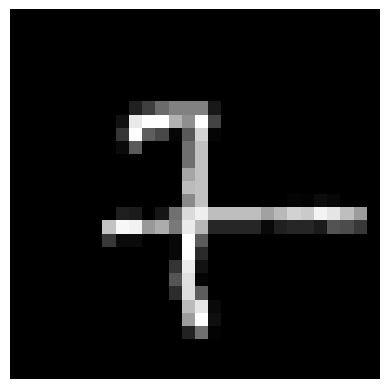

=== END Test Sample 3751


In [62]:
idx_wrong = np.nonzero(predictions != test_labels)[0]
np.random.seed(123)
samp = np.random.choice(idx_wrong, 5, replace=False)

for idx in samp:
  log_prob = np.log(pi[label]) + rv.logpdf(test_data[i,:])
  print(f"=== Test Sample {idx}, True label {test_labels[idx]}, Predicted Label {predictions[idx]}")
  score_row = score[idx]
  log_px = -np.inf
  for s in score_row:
    log_px = np.logaddexp(log_px, s)
  for i in range(10):
    print(f"\t[{i}], log(P({i}|x)) = {score_row[i] - log_px:10.4f}, P({i}|x) = {np.exp(score_row[i] - log_px):0.6f}")

  displaychar(test_data[idx])
  print(f"=== END Test Sample {idx}")